In [1]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%load_ext autoreload
%autoreload 2

2023-08-02 11:20:08.626765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
adata = sc.read_h5ad('../EEL_AnnData/EEL_41CleanNuclei-CellularNgh_FeaturesMN.h5ad')


In [22]:
palette = {
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    
    # AC-like 3, MN33 very noisy for NN analysis
    #'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'MES-like 2': '#EDE8F3',
    'MES-like 3': '#E2D8EA',
    'MES-like 1': '#D6BEDD',
    'MES-like 5': '#CFA8D1',
    'MES-like 4': '#CA90C5',
    'MES-like 7': '#D873B6',
    'MES-like 8': '#C50F53',
    'MES-like 6': '#840034',
        
    
    'NPC-like 1':'#FFF192',
    'NPC-like 2':'#FFF192',
    'NPC-like 3':'#FFF192',
    
    'RG 1':'#ff9470',
    'RG 2':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    'OPC-like 3':'#89c4f4', #bright turquoise
    
    #'Endothelial':'#d5b8ff', #mauve
    'Endothelial 1':'#8c14fc',#'#d5b8ff', #mauve
    'Endothelial':'#8c14fc',#'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    'Mural cell 1': '#8c14fc',  #electric indigo
    'Mural': '#8c14fc',  #electric indigo
    
    'Fibroblast': '#fbe7ef',
    'FB-like 2': '#FF6EC7', #fff9de
    'FB-like 3': '#FF6EC7', #fff9de
     #'FB-like 1': '#FF6EC7', #fff9de

    'Mono 1': '#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#FBFCFA',
    
    'TAM-MDM 1':'#e88474',#'#F5C9B0',
    'TAM-MDM 2':'#A94A54',
    
    'TAM-MDM 3':'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-MDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-BDM 1':'#e88474',#'#F5C9B0',
    'TAM-BDM 2':'#A94A54',
    
    'TAM-BDM 3':'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    
    'DC': '#a6915c',
}

palette_classes = {
    'GBL-like':'#c2f970',#'#c2f970'
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'preOPC-like':'#7befb2',#'#c2f970'

    #'MES-like': '#EDE8F3',
    'MES-like': '#e76d89',
    'NPC-like':'#FFF192',
    'RG':'#ff9470',
    
    'OPC-like':'#89c4f4',

    'FB-like': '#f1e7fe',#'#FF6EC7', #fff9de

}

In [23]:
import pandas as pd
adata.obs['Class'] = pd.Categorical(['unknown' if x.count('FB-like 1') else x for x in adata.obs['CombinedNameMergeImmune']])
adata.obs['Class'] = pd.Categorical([x.split(' ')[0] for x in adata.obs.Class])

In [24]:
'''adata.obs['CombinedNameMergeTemp'] = pd.Categorical(
    [
        'Endothelial' if x == 7 and cn.count('unknown') else cn for x,cn in zip(adata.obs.MolecularNgh, adata.obs.CombinedNameMergeTemp)
    ]
)

'''

"adata.obs['CombinedNameMergeTemp'] = pd.Categorical(\n    [\n        'Endothelial' if x == 7 and cn.count('unknown') else cn for x,cn in zip(adata.obs.MolecularNgh, adata.obs.CombinedNameMergeTemp)\n    ]\n)\n\n"

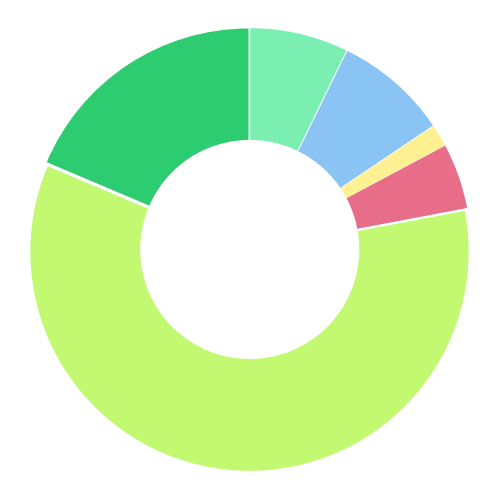

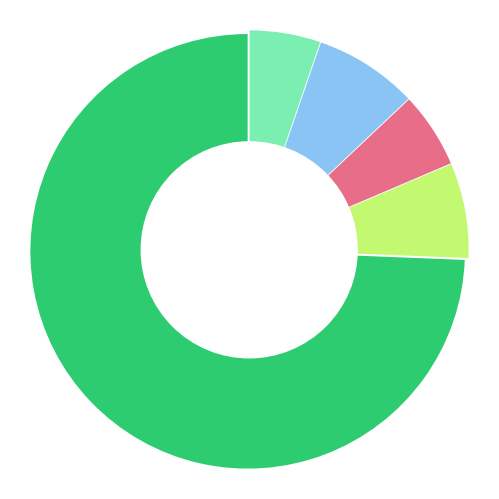

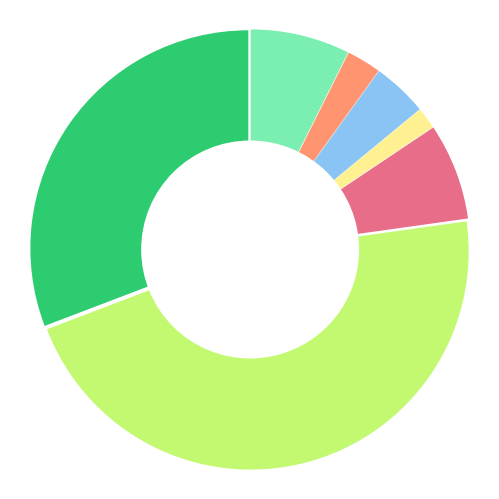

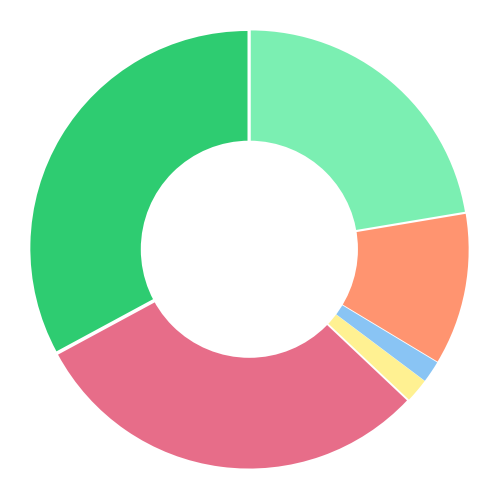

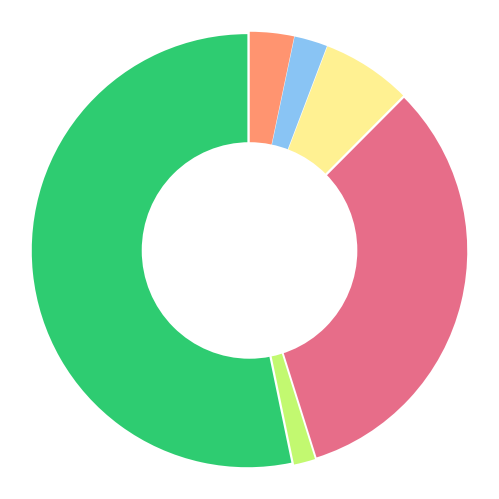

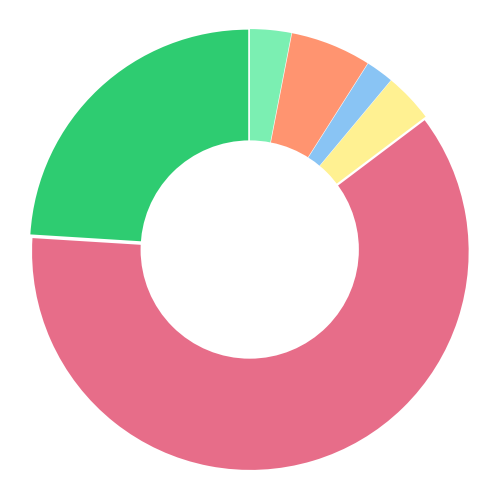

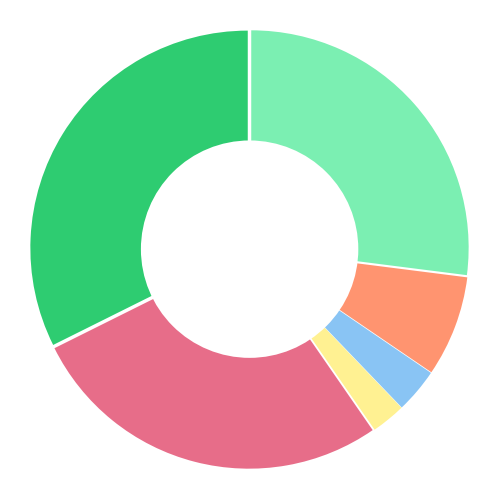

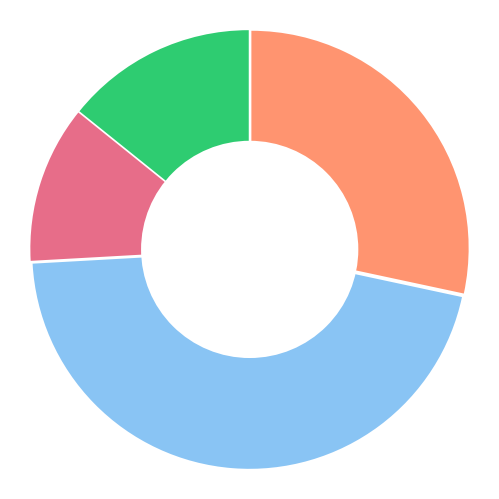

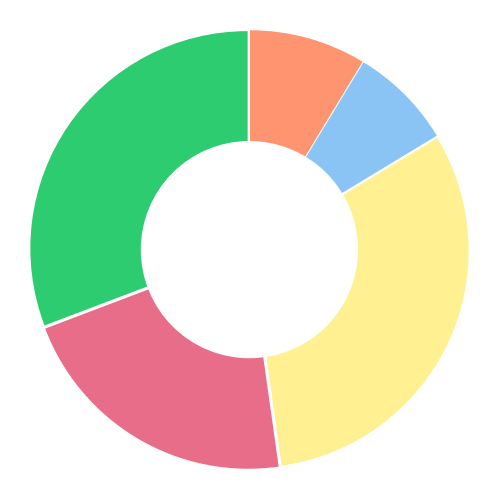

In [26]:
import matplotlib.pyplot as plt
# Pie chart
for s in ['SL001A','SL001B', 'SL003','SL006', 'SL046C','SL035B', 'SL061B', 'SL023', 'SL034']:
    sadata = adata[adata.obs.Sample == s]
    sadata = sadata[sadata.X.sum(axis=1)>20]
    
    #df_table = sadata.obs.pivot_table(values='Area', index='Class', aggfunc=np.sum)
    #df_table = df_table.loc[list(palette_classes.keys()),:]
    #p = df_table.Area/df_table.Area.sum() *100
    #df_table = df_table[p > 2.5]
    #classes = df_table.index.values
    #counts = df_table.Area.values
    
    classes, counts = np.unique(sadata.obs['Class'], return_counts=True)
    
    counts = counts[np.isin(classes,  list(palette_classes.keys()))]
    classes = classes[np.isin(classes, list(palette_classes.keys()))]
    
    p = counts/counts.sum() *100 > 1.5
    counts = counts[p]
    classes = classes[p]
    
    

    labels = [c.split('-')[0] for c in classes]
    sizes = counts
    #colors
    colors = [palette_classes[x] for x in classes]
    #explsion
    explode = [0.01 for c in classes]
    fig1, ax1 = plt.subplots(1,1,figsize=(5,5))
    kwargs={'fontsize':16},
    ax1.pie(
        sizes, 
        colors = colors, 
        #labels=labels, 
        #autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85,
        labeldistance=0.75,
        explode = explode,
        textprops={'fontsize': 12}
        #kwargs=**kwargs,
    )
    #draw circle
    centre_circle = plt.Circle((0,0),0.50,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig(f'figures/pie{s}.pdf',transparent=True)
    plt.show()

In [ ]:

sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    palette=palette,
    #geometry_key='Centroid',
    cluster_key= 'Class',
    clusters = ['AC-like','Mural','Endothelial'],
    markersize=.25,
    figsize=(5,5),

    show_scalebar=True,
    show_axis=False,
    save=True,
    savepath='figures/SL061B.svg',
    
)

In [ ]:
xlim= (2000, 8000)
ylim = (4000, 7000)

fig,ax = plt.subplots(1,1 ,figsize=(10,10))
sp.pl.plot_polygons_expression(
    adata,
    sample='SL061B',
    genes=['CRYAB'],
    cmap='Greens',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    mquant=0.995,
    ax = ax
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=0.9,
    show_axis=True,
    palette= {'Endothelial':'#8c14fc',  'Mural': '#8c14fc'},
    ax=ax,
)

plt.savefig('figures/CRYAB_SL061B.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')

In [ ]:
xlim= (2000, 8000)
ylim = (4000, 7000)

fig,ax = plt.subplots(1,1 ,figsize=(5,5))
sp.pl.plot_polygons_expression(
    adata,
    sample='SL061B',
    genes=['CRYAB'],
    cmap='Greens',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=True,
    #figsize=(5,5),
    mquant=0.995,
    ax = ax
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=0.9,
    show_axis=True,
    palette= {'Endothelial':'#8c14fc',  'Mural': '#8c14fc'},
    ax=ax,
)

In [ ]:
xlim= (5500, 6000)
ylim = (4750, 5250)


fig,ax = plt.subplots(1,1 ,figsize=(5,5))
sp.pl.plot_polygons_expression(
    adata,
    sample='SL061B',
    genes=['CRYAB'],
    cmap='Greens',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    mquant=0.995,
    ax = ax
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=0.9,
    show_axis=False,
    palette= {'Endothelial':'#8c14fc',  'Mural': '#8c14fc'},
    ax=ax,
)
plt.savefig('figures/CRYAB_SL061B_zoom.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')

In [ ]:
from FISHscale.utils.dataset import Dataset
from skimage import img_as_bool
from skimage.transform import rescale
import zarr

DS = Dataset('/wsfish/glioblastoma/EEL/Phase1/Analysis/JJEXP20220725_EEL_SL061B_S1/JJEXP20220725_EEL_SL061B_S1_RNA_transformed_assigned.parquet',
             gene_label='decoded_genes',
             pixel_size='0.27 micrometers',
             reparse=True,
            )

img = zarr.load('/date/sl/fish_rawdata/JJEXP20220725_EEL_SL061B_S1/fresh_tissue/segmentation/image_segmented_labels.zarr/segmented_labels_image/')
#img = np.flip(img, axis=0)
img[img >0] = 1
img_d = rescale(img, 0.27, anti_aliasing=False)
img_d[img_d >0] = 1
img_d = img_as_bool(img_d)
#x1, y1, x2, y2 = x1*0.27, y1*0.27, x2*0.27, y2*0.27



In [ ]:

DS.color_dict['FN1'] = mcolors.rgb2hex(palette['Mural'])
DS.color_dict['ITM2A'] = mcolors.rgb2hex('#d5b8ff')
DS.color_dict['CLDN5'] = mcolors.rgb2hex('#e33d94')

DS.color_dict['CRYAB'] = mcolors.rgb2hex(palette_classes['AC-like'])
DS.color_dict['AQP4'] = mcolors.rgb2hex('#038aff')


In [ ]:
'''xlim= (2000, 8000)
ylim = (4000, 7000)

xlim= (5500, 6000)
ylim = (4750, 5250)

xlim_rev = ()
ylim_rev = ()

v =  [[xlim[0], ylim[0]],[xlim[1],ylim[1]]]

scale_factor = 1#0.27*4.5
img_zoom = img_d[int(v[0][1]*scale_factor):int(v[1][1]*scale_factor),int(v[0][0]*scale_factor):int(v[1][0]*scale_factor)]

sizes = [20, 20, 20, 10] 
genes = ['FN1','CRYAB','CLDN5','AQP4']

fig,ax = plt.subplots(1,1 ,figsize=(5,5))

DS.scatter_plot(
    genes,
    s=sizes,
    ax_scale_factor=400,
    show_axes=True,
    show_legend=False,
    view = v,
    image=img_zoom,
    reset_xy=True,
    ax=ax,
    #save=True,
    #save_name='figures/SL061B.svg'
)

sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=0.9,
    show_axis=True,
    palette= {'Endothelial':'#8c14fc',  'Mural': '#8c14fc'},
    ax=ax,
)

'''

In [ ]:
xlim= (2000, 8000)
ylim = (4000, 7000)

xlim= (5500, 6000)
ylim = (4750, 5250)

xlim_rev = ()
ylim_rev = ()

v =  [[xlim[0], ylim[0]],[xlim[1],ylim[1]]]

scale_factor = 1#0.27*4.5
img_zoom = img_d[int(v[0][1]*scale_factor):int(v[1][1]*scale_factor),int(v[0][0]*scale_factor):int(v[1][0]*scale_factor)]

sizes = [20, 20, 20, 10, 10] 
genes = ['FN1','CRYAB','ITM2A','CLDN5','AQP4']

fig,ax = plt.subplots(1,1 ,figsize=(5,5))

DS.scatter_plot(
    genes,
    s=sizes,
    ax_scale_factor=400,
    show_axes=True,
    show_legend=True,
    view = v,
    image=img_zoom,
    reset_xy=True,
    ax=ax,
    save=True,
    save_name='figures/SL061B_dots.svg'
)



# Oligodendroglioma

In [ ]:
import matplotlib.pyplot as plt
# Pie chart
for s in ['SL003','SL012']:
    sadata = adata[adata.obs.Sample == s]
    sadata = sadata[sadata.X.sum(axis=1) > 25]
    
    #df_table = sadata.obs.pivot_table(values='Area', index='Class', aggfunc=np.sum)
    #df_table = df_table.loc[list(palette_classes.keys()),:]
    #classes = df_table.index.values
    #counts = df_table.Area.values
    
    #classes, counts = np.unique(sadata.obs['Class'], return_counts=True)
    #counts = counts[np.isin(classes,  list(palette_classes.keys()))]
    #classes = classes[np.isin(classes, list(palette_classes.keys()))]
    
    classes, counts = np.unique(sadata.obs['Class'], return_counts=True)
    counts = counts[np.isin(classes,  list(palette_classes.keys()))]
    classes = classes[np.isin(classes, list(palette_classes.keys()))]
    
    p = counts/counts.sum() *100 > 1.5
    counts = counts[p]
    classes = classes[p]

    labels = classes
    sizes = counts
    #colors
    colors = [palette_classes[x] for x in classes]
    #explsion
    explode = [0.01 for c in classes]
    fig1, ax1 = plt.subplots(1,1,figsize=(5,5))
    kwargs={'fontsize':16},
    ax1.pie(
        sizes, 
        colors = colors, 
        #labels=labels, 
        #autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85, 
        explode = explode,
        textprops={'fontsize': 12}
        #kwargs=**kwargs,
    )
    #draw circle
    centre_circle = plt.Circle((0,0),0.50,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig(f'figures/pie{s}.pdf')
    plt.show()

In [ ]:
palette_OL = {'Endothelial':'#8c14fc',  'Mural': '#8c14fc'} | palette_classes

In [ ]:
fig,ax = plt.subplots(1,1 ,figsize=(10,10))
sp.pl.plot_polygons(
    adata,
    sample='SL003',
    cluster_key='Class',
    clusters=['GBL-like', 'AC-like', 'OPC-like'], #[45,76],
    alpha=0.9,
    show_axis=True,
    palette= palette_OL,
    ax = ax,

    

)

sp.pl.plot_polygons(
    adata,
    sample='SL003',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    alpha=0.9,
    palette= palette_OL,
    ax=ax,
    show_axis=True
)
#plt.savefig('figures/SL003.svg')


In [ ]:
fig,ax = plt.subplots(1,1 ,figsize=(10,10))

sp.pl.plot_polygons_expression(
    adata,
    sample='SL003',
    genes=['EDNRB'],
    cmap='Greens',
    plot_grays=False,
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    #xlim=xlim,
    #ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    mquant=0.9999,
    ax=ax,
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

sp.pl.plot_polygons_expression(
    adata,
    sample='SL003',
    genes=['OLIG2'],
    cmap='Blues',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    #xlim=xlim,
    #ylim=ylim,
    alpha=1,
    plot_grays=False,
    show_axis=True,
    #figsize=(5,5),
    mquant=0.9999,
    ax=ax,
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

plt.savefig('figures/SL003_OLIG1_EDNRB.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')

In [ ]:
from FISHscale.utils.dataset import Dataset
from skimage import img_as_bool
from skimage.transform import rescale
import zarr

DS = Dataset('/wsfish/glioblastoma/EEL/Phase1/Analysis/JJEXP20220210_EEL_SL003_S1/JJEXP20220210_EEL_SL003_S1_RNA_transformed_assigned.parquet',
             gene_label='decoded_genes',
             pixel_size='0.27 micrometers',
             reparse=True,
            )

img = zarr.load('/datc/sl/fish_rawdata/JJEXP20220210_EEL_SL003_S1/fresh_tissue/segmentation/image_segmented_labels.zarr/segmented_labels_image/')
#img = np.flip(img, axis=0)
img[img >0] = 1
img_d = rescale(img, 0.27, anti_aliasing=False)
img_d[img_d >0] = 1
img_d = img_as_bool(img_d)
#x1, y1, x2, y2 = x1*0.27, y1*0.27, x2*0.27, y2*0.27



In [ ]:

DS.color_dict['FN1'] = mcolors.rgb2hex(palette['Mural'])
DS.color_dict['ITM2A'] = mcolors.rgb2hex('#d5b8ff')
DS.color_dict['CLDN5'] = mcolors.rgb2hex('#e33d94')

DS.color_dict['CRYAB'] = mcolors.rgb2hex(palette_classes['AC-like'])
DS.color_dict['AQP4'] = mcolors.rgb2hex('#038aff')

In [ ]:

xlim= (8000, 9000)
ylim = (2000, 3000)

xlim_rev = ()
ylim_rev = ()

v =  [[xlim[0], ylim[0]],[xlim[1],ylim[1]]]

scale_factor = 1#0.27*4.5
img_zoom = img_d[int(v[0][1]*scale_factor):int(v[1][1]*scale_factor),int(v[0][0]*scale_factor):int(v[1][0]*scale_factor)]

sizes = [20, 20, 20, 10, 10] 
genes = ['FN1','CRYAB','ITM2A','CLDN5','AQP4']

fig,ax = plt.subplots(1,1 ,figsize=(5,5))

DS.scatter_plot(
    genes,
    s=sizes,
    ax_scale_factor=400,
    show_axes=True,
    show_legend=True,
    view = v,
    image=img_zoom,
    reset_xy=True,
    ax=ax,
    save=True,
    save_name='figures/SL003_dots.svg'
)
